In [120]:
import matplotlib.pyplot as plt
import os
import numpy as np
from time import time
import cv2

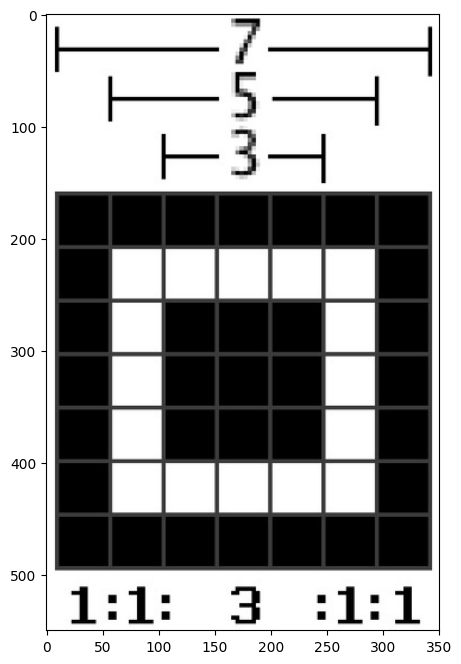

In [121]:
plt.figure(figsize=(6, 8))
img_color = cv2.imread("/content/applsci-10-07814-g003-550.jpg",1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

можем заметить, что соотнашение угловых квадравтов в qr-code, 7:5:3, можно тогда, соотнашение плошадей будет анологично 49:25:9 с какой-то погрешностью.

In [122]:
class QrCodeDetector:
    def __init__(self, area_proportions=None, threshold_rate=0.33):
        self.area_proportions = area_proportions or [(49, 25), (49, 9), (25, 9)]
        self.threshold_rate = threshold_rate
      
    
    def get_updated_image(self, image):
      edges = self.extract_edges(self.preprocess_image(image))
      contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      finder_pattern_contours = self.find_finder_pattern_contours(contours, hierarchy[0])
      cv2.drawContours(image, finder_pattern_contours, -1, (0, 0, 255), 6)
      return image

    def has_correct_area_proportions(self, areas):
        outer_black_area = areas[0]
        for i, inner_white_area in enumerate(areas[1:-1]):
            for inner_black_area in areas[i+1:]:
                for area_proportion in self.area_proportions:
                    is_ratio = np.abs(outer_black_area / inner_black_area - area_proportion[0] / area_proportion[1]) \
                                < (area_proportion[0] / area_proportion[1]) * self.threshold_rate
                    if is_ratio:
                        return True
        return False
    
    def preprocess_image(self, image):
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = cv2.GaussianBlur(image, (7, 7), 0)
      image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
      kernel = np.ones((4, 4), np.uint8)
      image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
      image = cv2.erode(image, np.ones((3, 3)), iterations=1)
      return image


    def extract_edges(self, grey_image):
      edges = cv2.Canny(grey_image, 80, 110)
      edges = (edges != 0).astype(np.uint8)
      edges = cv2.dilate(edges, np.ones((3, 3)))
      return edges

    def find_finder_pattern_contours(self, contours, hierarchy):
      processed_contours = set()
      finder_patterns = []
      for i, cnt in enumerate(contours):
          if i in processed_contours:
              continue
          child_areas = []
          processed_child_contours = set()
          j = i
          while hierarchy[j][2] != -1:
              child_areas.append(cv2.contourArea(contours[j]))
              processed_child_contours.add(j)
              j = hierarchy[j][2]
          if self.area_proportions[2][1] < len(child_areas) < self.area_proportions[0][0]:
              if self.has_correct_area_proportions(child_areas):
                  finder_patterns.append(cnt)
                  processed_contours.union(processed_child_contours)
      
      return finder_patterns

In [123]:
def qr_code_detect(images_folder_path):
  start_time = time()
  os.mkdir(images_folder_path + '_results/')
  for image_name in os.listdir(images_folder_path):
    image = cv2.imread(os.path.join(images_folder_path, image_name))
    detector = QrCodeDetector()
    detector.get_updated_image(image)
    cv2.imwrite(images_folder_path + '_results/' + image_name, image)
  end_time = time()
  print("Full time for folder is = ", end_time - start_time)
  print("time on one image is = ", (end_time - start_time) / len(os.listdir(images_folder_path)))


Если выделение внешнего края внешнего квадрата является ошибкой, т.е.
- если один из трех квадратов - TP
- если не один из трех квадратов - FN
- если выделен не квадрать(из этих трех) - FP

In [130]:
qr_code_detect("TestSet1")

Full time for folder is =  24.94384527206421
time on one image is =  0.5307201121715789


$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \approx 0.972$$

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} \approx 0.854$$

In [131]:
qr_code_detect("TestSet2")

Full time for folder is =  29.176558017730713
time on one image is =  0.6078449587027231


$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} \approx 0.912$$

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} \approx 0.841$$
